In [27]:
import sys
import copy

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import shortest_path

sys.path.insert(0, '..')
from neigh_gf_src import datasets as ds
from neigh_gf_src.arch import GraphDecoder, GraphDeepDecoder
from neigh_gf_src.model import ModelSamuel

SEED = 10
torch.manual_seed(SEED)
np.random.seed(SEED)

In [28]:
def create_filter(S, ps, x=None):
    if ps['type'] == 'BLH':
        _, V = ordered_eig(S)
        V = np.real(V)
        eigvalues = np.ones(V.shape[0])*0.001
        bl_k = int(S.shape[0]*ps['k'])
        if ps['firsts']:
            eigvalues[:bl_k] = 1
        else:
            x_freq = V.T.dot(x)
            idx = np.flip(np.abs(x_freq).argsort(), axis=0)[:bl_k]
            eigvalues[idx] = 1

        H = V.dot(np.diag(eigvalues).dot(V.T))
    elif ps['type'] == 'RandH':
        hs = np.random.rand(ps['K'])
        hs /= np.sum(hs)
    elif ps['type'] == 'FixedH':
        hs = ps['hs']
    else:
        print('Unkwown filter type')
        return None

    if ps['neigh']:
        H = np.zeros((S.shape))
        distances = shortest_path(S, directed=False, unweighted=True)
        for l, h in enumerate(hs):
            H += h*(distances == l).astype(int)            
    elif ps['type'] != 'BLH':
        H = np.zeros((S.shape))
        for l, h in enumerate(hs):
            H += h*np.linalg.matrix_power(S, l)
        
    if ps['H_norm']:
        H /= np.linalg.norm(H)

    return H

## Test with 2layers decoder and piecewise signal

True


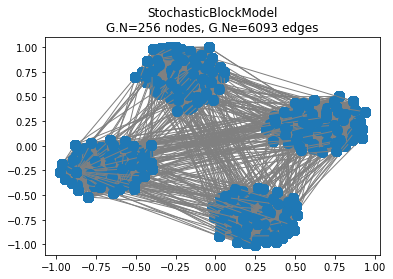

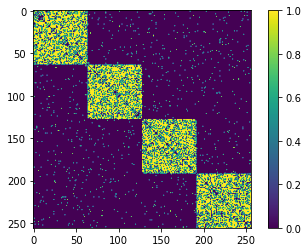

In [34]:
Gs = {}
Gs['type'] = ds.SBM
Gs['N'] = 256
Gs['k'] = 4
Gs['type_z'] = ds.CONT
Gs['p'] = 0.7
Gs['q'] = 0.015

G = ds.create_graph(Gs, SEED)
A = np.asarray(G.W.todense())
G.plot()

plt.figure()
plt.imshow(A)
plt.colorbar()
print(np.array_equal(A, A.astype(bool)))

[0.3, 0.6, 0.1]


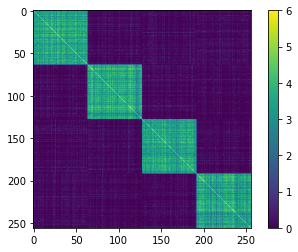

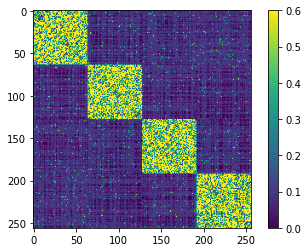

In [4]:
# hs = [0.3, 0.4, 0.2, 0.1]

hs = [0.3, 0.6, 0.1]
#K = 3
#hs = np.random.rand(K)
#hs /= np.sum(abs(hs))
print(hs)

h_params = {'type': 'FixedH', 'hs': hs, 'H_norm': False, 'neigh': False}
H = create_filter(A, h_params)

plt.figure()
plt.imshow(H)
plt.colorbar()

h_params_n = {'type': 'FixedH', 'hs': hs, 'H_norm': False, 'neigh': True}
Hn = create_filter(A, h_params_n)

plt.figure()
plt.imshow(Hn)
plt.colorbar()

In [5]:
n_signals = 50
n_p = 0.2
fts = 150
epochs = 500
lr = .0025
scale_std = .01

err = np.zeros((2, epochs, n_signals))
for i in range(n_signals):
    dec = GraphDecoder(fts, H, scale_std=scale_std)
    dec_n = GraphDecoder(fts, Hn, scale_std=scale_std)
    
    x = G.info['node_com']
    xp = np.linalg.norm(x)**2
    noise = np.random.randn(x.size)*np.sqrt(xp*n_p/x.size)
    x_n = x + noise
    
    model = ModelSamuel(dec, epochs=epochs, learning_rate=lr)
    model_n = ModelSamuel(dec_n, epochs=epochs, learning_rate=lr)
    _, err[0, :, i], _ = model.fit(x_n, x, reduce_err=True)/xp
    _, err[1, :, i], _ = model_n.fit(x_n, x, reduce_err=True)/xp
    
    print(i, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

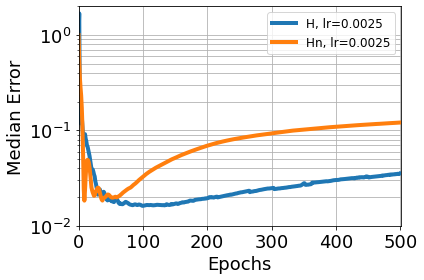

In [6]:
err_med = np.median(err, axis=2)

fig = plt.figure()
plt.semilogy(err_med[0,:], linewidth=4, label='H, lr={}'.format(lr))
plt.semilogy(err_med[1,:], linewidth=4, label='Hn, lr={}'.format(lr))
plt.legend(prop={'size': 12})
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Median Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([1e-2, 2])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

In [7]:
n_signals = 50
n_p = 0.2
fts = 200
epochs = 750
lr = .005
scale_std = .01

err2 = np.zeros((2, epochs, n_signals))
for i in range(n_signals):
    dec = GraphDecoder(fts, H, scale_std=scale_std)
    dec_n = GraphDecoder(fts, Hn, scale_std=scale_std)
    
    x = G.info['node_com']
    xp = np.linalg.norm(x)**2
    noise = np.random.randn(x.size)*np.sqrt(xp*n_p/x.size)
    x_n = x + noise
    
    model = ModelSamuel(dec, epochs=epochs, learning_rate=lr)
    model_n = ModelSamuel(dec_n, epochs=epochs, learning_rate=lr)
    _, err2[0, :, i], _ = model.fit(x_n, x, reduce_err=True)/xp
    _, err2[1, :, i], _ = model_n.fit(x_n, x, reduce_err=True)/xp
    
    print(i, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

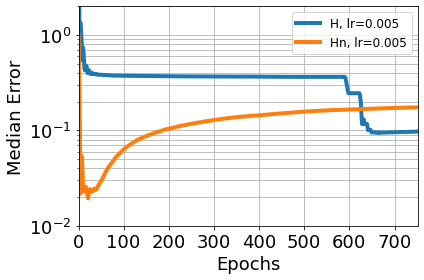

In [8]:
err_med = np.median(err2, axis=2)

fig = plt.figure()
plt.semilogy(err_med[0,:], linewidth=4, label='H, lr={}'.format(lr))
plt.semilogy(err_med[1,:], linewidth=4, label='Hn, lr={}'.format(lr))
plt.legend(prop={'size': 12})
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Median Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([1e-2, 2])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

## Test 2L and deep decoder with DW signal 

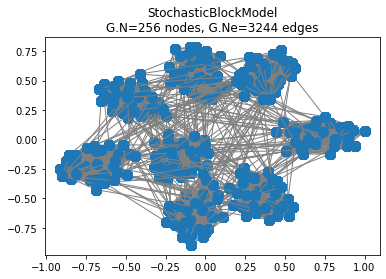

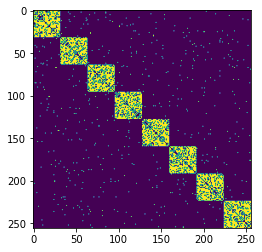

In [9]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Graph parameters
G_params = {}
G_params['type'] = ds.SBM
G_params['k'] = 8
G_params['type_z'] = ds.CONT
G_params['N'] = 256
G_params['p'] = 0.75
G_params['q'] = 0.0075

G = ds.create_graph(G_params, SEED)
S = np.asarray(G.W.todense())

G.plot()
plt.figure()
plt.imshow(S)

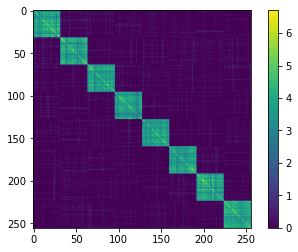

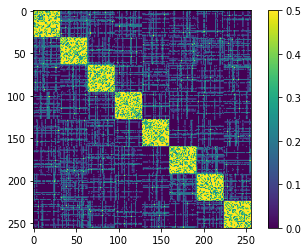

In [10]:
#hs = [0.3, 0.4, 0.2, 0.1]
hs = [0.3, 0.5, 0.2]

h_params = {'type': 'FixedH', 'hs': hs, 'H_norm': False, 'neigh': False}
H = create_filter(S, h_params)

plt.figure()
plt.imshow(H)
plt.colorbar()

h_params_n = {'type': 'FixedH', 'hs': hs, 'H_norm': False, 'neigh': True}
Hn = create_filter(S, h_params_n)

plt.figure()
plt.imshow(Hn)
plt.colorbar()

In [11]:
Exps = [{'H': H, 'fts': 150, 'std': 0.1, 'legend': '2L-DecH'},
        {'H': Hn, 'fts': 150, 'std': 0.1, 'legend': '2L-DecHn'}
        ]

n_signals = 25
n_p = 0.1
epochs = 500
lr = 0.05

In [12]:
err3 = np.zeros((2*len(Exps), n_signals, epochs))
for i in range(n_signals):
    w = np.random.randn(G.N)
    x1 = H@w
    x2 = Hn@w
    x1_p = np.linalg.norm(x1)**2
    x2_p = np.linalg.norm(x2)**2
    
    noise = np.random.randn(G.N)
    x1_n = x1 + noise*np.sqrt(x1_p*n_p/x1.size)
    x2_n = x2 + noise*np.sqrt(x2_p*n_p/x2.size)
    
    for j, exp in enumerate(Exps):
        dec = GraphDecoder(exp['fts'], exp['H'], exp['std'])
        model1 = ModelSamuel(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
        model2 = ModelSamuel(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)

        _, err3[2*j, i, :], _ = model1.fit(x1_n, x1)/x1_p
        _, err3[2*j+1, i, :], _ = model2.fit(x2_n, x2)/x2_p
    
    print(i, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

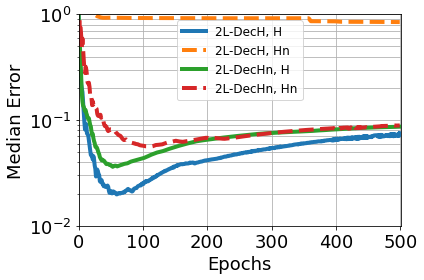

In [13]:
err_med = np.median(err3, axis=1)

leg = []
for i, exp in enumerate(Exps):
    leg.append(exp['legend']+', H')
    leg.append(exp['legend']+', Hn')

fig = plt.figure()
plt.semilogy(err_med[0,:], '-', linewidth=4)
plt.semilogy(err_med[1,:], '--', linewidth=4)
plt.semilogy(err_med[2,:], '-', linewidth=4)
plt.semilogy(err_med[3,:], '--', linewidth=4)
plt.legend(leg, prop={'size': 12})
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Median Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([1e-2, 1])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

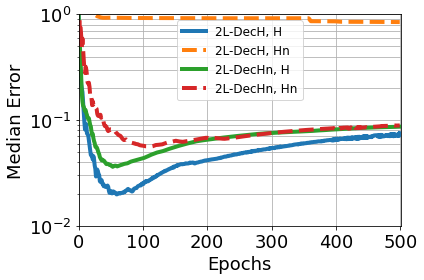

In [14]:
# Con lr = 0.025
err_med = np.median(err3, axis=1)

leg = []
for i, exp in enumerate(Exps):
    leg.append(exp['legend']+', H')
    leg.append(exp['legend']+', Hn')

fig = plt.figure()
plt.semilogy(err_med[0,:], '-', linewidth=4)
plt.semilogy(err_med[1,:], '--', linewidth=4)
plt.semilogy(err_med[2,:], '-', linewidth=4)
plt.semilogy(err_med[3,:], '--', linewidth=4)
plt.legend(leg, prop={'size': 12})
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Median Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([1e-2, 1])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

In [24]:
Exps = [{'H': H, 'legend': 'DecH'},
        {'H': Hn, 'legend': 'DecHn'}]

n_signals = 10
n_p = 0.1
epochs = 1000
lr = 0.001
nodes = [256]*6
fts = [97]*5 + [1]
w_std = .1
in_std = .01

In [25]:
err4 = np.zeros((2*len(Exps), n_signals, epochs))
for i in range(n_signals):
    w = np.random.randn(G.N)
    x1 = H@w
    x2 = Hn@w
    
    #x1 /= np.linalg.norm(x1)
    #x2 /= np.linalg.norm(x2)
    
    x1_p = np.linalg.norm(x1)**2
    x2_p = np.linalg.norm(x2)**2
    
    noise = np.random.randn(G.N)
    x1_n = x1 + noise*np.sqrt(x1_p*n_p/x1.size)
    x2_n = x2 + noise*np.sqrt(x2_p*n_p/x2.size)
    
    for j, exp in enumerate(Exps):
        dec = GraphDeepDecoder(fts, nodes,exp['H'], act_fn=nn.ReLU(),
                               last_act_fn=None, input_std=in_std,
                               w_std=w_std)
        
        model1 = ModelSamuel(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
        model2 = ModelSamuel(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)

        _, err4[2*j, i, :], _ = model1.fit(x1_n, x1)/x1_p
        _, err4[2*j+1, i, :], _ = model2.fit(x2_n, x2)/x2_p
    
    print(i, end=' ')

0 1 2 3 4 5 6 7 8 9 

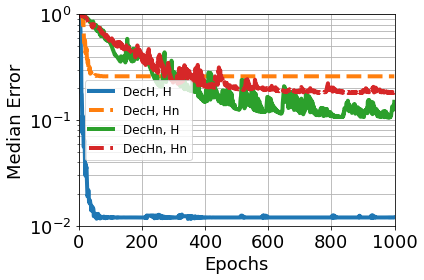

In [26]:
err_med = np.median(err4, axis=1)

leg = []
for i, exp in enumerate(Exps):
    leg.append(exp['legend']+', H')
    leg.append(exp['legend']+', Hn')

fig = plt.figure()
plt.semilogy(err_med[0,:], '-', linewidth=4)
plt.semilogy(err_med[1,:], '--', linewidth=4)
plt.semilogy(err_med[2,:], '-', linewidth=4)
plt.semilogy(err_med[3,:], '--', linewidth=4)
plt.legend(leg, prop={'size': 12})
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Median Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([1e-2, 1])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()